# Голосовая активация на шумных данных

In [1]:
from typing import List

import os

import numpy as np
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchaudio

from matplotlib import pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

In [2]:
# Если есть настроенное gpu, то можно просто cuda, либо cuda:gpu_id
# Либо 'cpu' в случае обучения на CPU
DEVICE = 'cuda:1'

In [3]:
# Путь по которому распакован архив с данными
START_PATH = './../../spotter_denoiser_data'

In [4]:
# Список классов для предсказаний
CLASSES = [
    'дальше',
    'вперед',
    'назад',
    'вверх',
    'вниз',
    'выше',
    'ниже',
    'домой',
    'громче',
    'тише',
    'лайк',
    'дизлайк',
    'следующий',
    'предыдущий',
    'сначала',
    'перемотай',
    'выключи',
    'стоп',
    'хватит',
    'замолчи',
    'заткнись',
    'останови',
    'пауза',
    'включи',
    'смотреть',
    'продолжи',
    'играй',
    'запусти',
    'ноль',
    'один',
    'два',
    'три',
    'четыре',
    'пять',
    'шесть',
    'семь',
    'восемь',
    'девять'
]

# Данные

В качестве тренировачных данных есть 2 сета:
- чистый сет с произношением различных голосовых команд, чтобы можно было обучать на них модель голосовой активации
- сет с шумами, чтобы можно было пытаться ими аугментировать записи для тренировки модели голосовой активации или денойзера

В качестве тестовых данных используются уже зашумлённые данные.


In [5]:
def add_noise(clean, noise, min_amp, max_amp):
    """
    Функция, которая используется для зашумления данных
    clean и noise -- это считанные аудиозаписи с чистой речью и шумом соответственно
    min_amp -- минимальное отношение мощности шума к мощности речи
    max_amp -- максимальное отношение мощности шума к мощности речи
    """
    # степень шума случайна от min_amp до max_amp
    noise_amp = np.random.uniform(min_amp, max_amp)
    # если запись с шумом короче, чем чистая, то она дублируется нужное число раз
    noise = noise.repeat(1, clean.shape[1] // noise.shape[1] + 2)
    # так как теперь шумная запись длиннее, то выбираем случайный момент начала шумной записи
    start = np.random.randint(0, noise.shape[1] - clean.shape[1] + 1)
    noise_part = noise[:, start:start+clean.shape[1]]
    # накладываем шум
    noise_mult = clean.abs().max() / noise_part.abs().max() * noise_amp
    return (clean + noise_part * noise_mult) / (1 + noise_amp)

In [6]:
class AudioDataset(Dataset):
    """
    Датасет умеющий выдавать чистые + грязные данные для тренировки,
    как модели голосовой активации, так и денойзера
    """
    def __init__(
        self, audio_path, noise_path=None,
        prepare_fun=torchaudio.transforms.MFCC(melkwargs={'n_mels': 80}),
        min_amp: float = 0.0, max_amp: float = 4.0
    ):
        """
        audio_path -- Путь к чистым данны
        noise_path -- Путь к шуму для накладывания на чистые данные, если нужен
        min_amp -- минимальное отношение мощности шума к мощности речи
        max_amp -- максимальное отношение мощности шума к мощности речи
        
        min_amp и max_amp можно варьировать, чтобы подготовить модель к различным видам зашумления.
        """
        super().__init__()
        self._prepare_fun = prepare_fun
        self._min_amp = min_amp
        self._max_amp = max_amp
        self._noise = None
        if audio_path is None:
            assert noise_path is None
            return
        self._pathes, self._labels = self._path_traversall(audio_path)
        if noise_path:
            noise, _ = self._path_traversall(noise_path)
            self._noise = [torchaudio.load(path)[0] for path in noise]

    @classmethod
    def _create_from_loaded(
        cls, pathes, labels, noise, prepare_fun, min_amp, max_amp
    ):
        """
        Создаёт новый датасет из уже подгруженного.
        Используется при сплите датасета на train и val.
        """
        obj = AudioDataset(
            None, prepare_fun=prepare_fun, min_amp=min_amp, max_amp=max_amp
        )
        obj._pathes = pathes
        obj._labels = labels
        obj._noise = noise
        return obj

    def _path_traversall(self, path, label=None):
        """
        Функция для обхода папки с данными
        """
        pathes = []
        labels = []
        for filename in os.listdir(path):
            if os.path.splitext(filename)[1] == '.wav':
                pathes.append(os.path.join(path, filename))
                labels.append(CLASSES.index(label) if label else None)
            elif os.path.isdir(os.path.join(path, filename)):
                new_pathes, new_labels = self._path_traversall(
                    os.path.join(path, filename), label=filename
                )
                pathes.extend(new_pathes)
                labels.extend(new_labels)
            else:
                raise RuntimeError(f'Unknorwn file extension for {filename}')
        return pathes, labels

    def __len__(self):
        return len(self._pathes)

    def __getitem__(self, idx):
        audio = None
        audio, _ = torchaudio.load(self._pathes[idx])
        return_dict = {
            'clean_feats': self._prepare_fun(audio)[0],
            'clean_audio': audio,
            'uttid': os.path.split(self._pathes[idx])[-1]
        }
        if self._noise is not None:
            # Если в класс передавались шумы, то тут происходит зашумление
            noise_idx = np.random.randint(0, len(self._noise))
            noise_audio = add_noise(
                audio, self._noise[noise_idx], self._min_amp, self._max_amp
            )
            return_dict['noise_audio'] = noise_audio
            return_dict['noise_feats'] = self._prepare_fun(noise_audio)[0]
        else:
            # Если же нет, то вместо шумов выдаётся чистый звук
            return_dict['noise_audio'] = return_dict['clean_audio']
            return_dict['noise_feats'] = return_dict['clean_feats']
        if self._labels[idx] is not None:
            return_dict['label'] = self._labels[idx]
        return return_dict

    def split(self, train_part=0.9, seed=42):
        """
        Функция для того чтобы разделить датасет на 2 части, например, на train и val.
        """
        np.random.seed(seed)
        train_pathes = []
        train_labels = []
        val_pathes = []
        val_labels = []
        for idx in range(len(self._pathes)):
            if np.random.rand() < train_part:
                train_pathes.append(self._pathes[idx])
                train_labels.append(self._labels[idx])
            else:
                val_pathes.append(self._pathes[idx])
                val_labels.append(self._labels[idx])
        return (
            AudioDataset._create_from_loaded(
                train_pathes, train_labels, self._noise, self._prepare_fun,
                self._min_amp, self._max_amp
            ),
            AudioDataset._create_from_loaded(
                val_pathes, val_labels, self._noise, self._prepare_fun,
                self._min_amp, self._max_amp
            )
        )

In [7]:
# Подгрузим тренировочный сет в двух вариантах: чистый и с зашумлением
fullcleanset = AudioDataset(os.path.join(START_PATH, 'speech_commands_train'))
traincleanset, valcleanset = fullcleanset.split()
fullnoiseset = AudioDataset(
    os.path.join(START_PATH, 'speech_commands_train'), noise_path=os.path.join(START_PATH, 'noises')
)
trainnoiseset, valnoiseset = fullnoiseset.split()
testset = AudioDataset(os.path.join(START_PATH, 'speech_commands_test'))

## Как выглядят полученные данные

Вот например чистые аудиофайлы:

In [8]:
random_idxes = np.random.randint(0, len(fullnoiseset), size=10)
for idx in random_idxes:
    ipd.display(ipd.Audio(fullnoiseset[idx]['clean_audio'], rate=16000))

А тут уже зашумлённые.

In [9]:
for idx in random_idxes:
    ipd.display(ipd.Audio(fullnoiseset[idx]['noise_audio'], rate=16000))

In [10]:
MAX_LEN = 0
for i in tqdm.trange(len(fullcleanset)):
    MAX_LEN = max(fullcleanset[i]['clean_feats'].shape[1], MAX_LEN)
print('max len of audio equal to', MAX_LEN, 'frames')

  0%|          | 0/93282 [00:00<?, ?it/s]

max len of audio equal to 321 frames


Несколько функций для того, чтобы покрыть нужную информацию в батче для разных тренировок.

In [11]:
def join_in_batch(batch, key):
    """
    Фунция для того, чтобы создать батч из аудиозаписей разной длины.
    """
    X = torch.zeros((len(batch), batch[0][key].shape[0], MAX_LEN))
    for i in range(len(batch)):
        diff = MAX_LEN - batch[i][key].shape[1]
        start = diff // 2
        end = MAX_LEN - diff + start
        if start != 0:
            X[i, :, :start] = batch[i][key][:, 0].reshape(-1, 1)
        X[i, :, start:end] = batch[i][key]
        if end != MAX_LEN:
            X[i, :, end:] = batch[i][key][:, -1].reshape(-1, 1)
    return X


# Дальше функции для того, чтобы склеить записи в один батч на все случаи жизни

def spotter_collate_fn(batch):
    X = join_in_batch(batch, 'noise_feats')
    Y = torch.tensor([item['label'] for item in batch])
    return X, Y

def denoiser_collate_fn(batch):
    X = join_in_batch(batch, 'noise_feats')
    Y = join_in_batch(batch, 'clean_feats')
    return X, Y

def test_collate_fn(batch):
    X = join_in_batch(batch, 'noise_feats')
    Y = [item['uttid'] for item in batch]
    return X, Y

# Модель голосовой активации

Модель голосовой активации на входе принимает матрицу из признаков размера (время $\times$ количество признаков). Поверх этого можно запустить достаточно простую свёрточную модель с 1d свёртками, ибо считаем, что нам интересны локальные зависимости в пространстве времени, а пространство признаков становится чем-то вроде пространства каналов в случае картинок.

In [12]:
def spotter_eval(model, val_data, batch_size=256):
    """
    Фунция подсчёта качества на валидационных модели на валидационных данных.
    """
    model.eval()
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    for X, Y in tqdm.tqdm(val_loader):
        preds = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(preds, Y.to(DEVICE))
        val_loss += loss.detach().cpu().data.numpy()
        val_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
        val_batches += 1
    return val_loss / val_batches, val_acc / val_batches
    

def spotter_train(model, train_data, val_data, n_epochs=10, batch_size=256):
    """
    Простая тренировка поданной на вход модели.
    В качестве оптимизатора используется Adam.
    Тренировка происходит заданное число эпох с константным lr.
    """
    optimizer = opt.Adam(model.parameters())
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    train_losses, train_accs = [], []
    val_losses,val_accs = [], []
    for epoch in range(n_epochs):
        train_loss, train_acc, train_batches = 0, 0, 0
        model.train()
        for X, Y in tqdm.tqdm(train_loader):
            preds = model.forward(X.to(DEVICE))
            loss = F.cross_entropy(preds, Y.to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.numpy()
            train_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
            train_batches += 1
        val_loss, val_acc = spotter_eval(model, val_data, batch_size=batch_size)
        train_losses.append(train_loss / train_batches)
        train_accs.append(train_acc / train_batches)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output(wait=True)
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(train_losses, label='train')
        axis[0].plot(val_losses, label='val')
        axis[1].plot(train_accs, label='train')
        axis[1].plot(val_accs, label='val')
        (ax.set_xlabel('epoch') for ax in axis)
        axis[0].set_ylabel('cross entropy loss')
        axis[1].set_ylabel('accuracy')
        (ax.legend() for ax in axis)
        plt.show()

In [13]:
class Conv1dModule(nn.Module):
    """
    Простой кирпичик для свёрточной модели.
    n_in -- число фильтров на входе
    n_out -- число фильтров на выходе
    kernel -- размер ядра
    pooling -- размер ядра пулинга
    batchnorm -- флаг отвечающий за использование батч нормализации
    relu -- флаг отвечающий за использование нелинейности
    """
    def __init__(self, n_in, n_out, kernel, pooling, batchnorm=False, relu=True):
        super().__init__()
        assert kernel % 2 == 1
        pad = kernel // 2
        modules = [nn.Conv1d(n_in, n_out, kernel, padding=pad)]
        if batchnorm:
            modules.append(nn.BatchNorm1d(n_out))
        if pooling > 1:
            modules.append(nn.MaxPool1d(pooling))
        if relu:
            modules.append(nn.ReLU())
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)


class Flatten(nn.Module):
    def forward(self, X):
        return X.reshape(X.shape[0], -1)


class FlattenModule(nn.Module):
    """
    Простой кирпичик полносвязной части свёрточной модели.
    n_in -- число нейронов на входе
    n_out -- число нейроново на выходе
    batchnorm -- флаг отвечающий за использование батч нормализации
    relu -- флаг отвечающий за использование нелинейности
    """
    def __init__(self, n_in, n_out, batchnorm=False, relu=True):
        super().__init__()
        modules = [nn.Linear(n_in, n_out)]
        if batchnorm:
            modules.append(nn.BatchNorm1d(n_out))
        if relu:
            modules.append(nn.ReLU())
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)


class Conv1dModel(nn.Module):
    """
    Пример простой сети для работы со звуком.
    Изначально несколько слоёв используют 1d свёртки, затем просходит конкатенация матрицы
    признаков в вектор и применяются несколько полносвязных слоёв.
    В целом тут всё очень сильно похоже на картинки.
    
    shapes -- число филтров в свёрточных слоях. На нулевом индексе число фильтров на входе.
        Далее число фильтров после каждого свёрточного слоя
    flatten_shapes -- число нейронов после применения линейных слоёв.
    kernels -- размеры ядер свёрточных слоёв
    poolings -- параметры пулинга после свёрточных слоёв
    batchnorm -- флаг отвечающий за использовать или нет нормализацию
    """
    def __init__(
        self, shapes: List[int], flatten_shapes: List[int], kernels: List[int],
        poolings: List[int], batchnorm=False
    ):
        super().__init__()
        assert len(kernels) + 1 == len(shapes)
        assert len(poolings) == len(kernels)
        modules = []
        start_flatten_shape = MAX_LEN
        for i in range(len(kernels)):
            modules.append(Conv1dModule(
                shapes[i], shapes[i + 1], kernels[i], poolings[i],
                batchnorm=batchnorm
            ))
            start_flatten_shape //= poolings[i]
        modules.append(Flatten())
        flatten_shapes = [start_flatten_shape * shapes[-1]] + flatten_shapes
        for i in range(len(flatten_shapes) - 1):
            modules.append(FlattenModule(
                flatten_shapes[i], flatten_shapes[i + 1], batchnorm=batchnorm, relu=i+2==len(flatten_shapes)
            ))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)

Сразу попробуем натренировать модель на чистых данных и применить на грязных

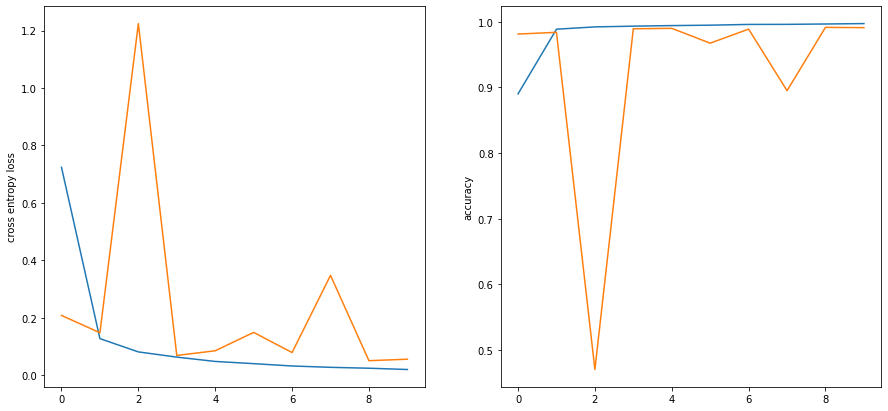

In [14]:
conv1d_clean_model = Conv1dModel(
    [40] + [256] * 7, [1024, 256, len(CLASSES)],
    [5] * 7, [1, 2] * 3 + [1], batchnorm=True
).to(DEVICE)
spotter_train(conv1d_clean_model, traincleanset, valcleanset, n_epochs=10, batch_size=256)

In [15]:
spotter_eval(conv1d_clean_model, valcleanset)

  0%|          | 0/36 [00:00<?, ?it/s]

(0.05645894740397731, 0.9911024305555556)

In [16]:
spotter_eval(conv1d_clean_model, valnoiseset)

  0%|          | 0/36 [00:00<?, ?it/s]

(6.507231778568691, 0.3509041329699953)

Как видно, модель натренированная на чистых данных, довольно плохо работает на грязных данных. Так что можно попробовать как минимум 2 выхода: натренировать модель на грязных данных и натренировать денойзер убирающий шум из грязных данных.

## Тренировка на грязных данных

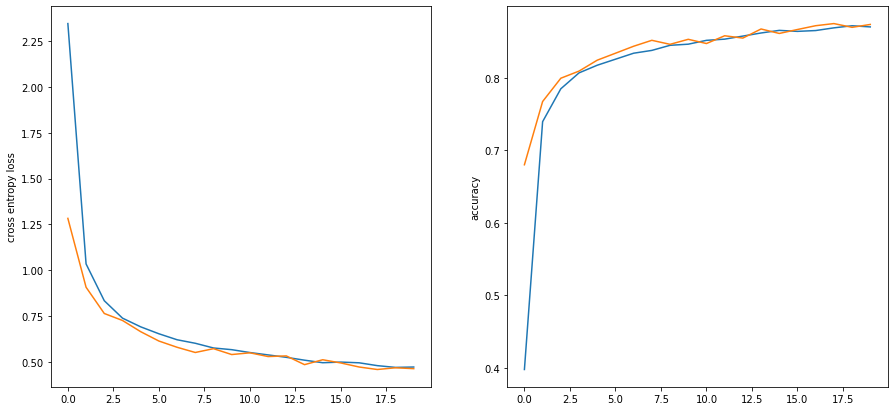

In [17]:
conv1d_noise_model = Conv1dModel(
    [40] + [256] * 7, [1024, 256, len(CLASSES)],
    [5] * 7, [2] * 7, batchnorm=True
).to(DEVICE)
spotter_train(conv1d_noise_model, trainnoiseset, valnoiseset, n_epochs=20)

In [18]:
spotter_eval(conv1d_noise_model, valnoiseset)

  0%|          | 0/36 [00:00<?, ?it/s]

(0.47195128434234196, 0.8733893357360525)

# Попробуем добавить денойзер

In [19]:
def denoiser_train(model, train_data, val_data, n_epochs=10, batch_size=256):
    optimizer = opt.Adam(model.parameters())
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, num_workers=4,
        collate_fn=denoiser_collate_fn
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=4,
        collate_fn=denoiser_collate_fn
    )
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        train_loss, train_batches = 0, 0
        model.train()
        for X, Y in tqdm.tqdm(train_loader):
            preds = model.forward(X.to(DEVICE))
            loss = F.mse_loss(preds, Y.to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.numpy()
            train_batches += 1
        val_loss, val_batches = 0, 0
        model.eval()
        for X, Y in tqdm.tqdm(val_loader):
            preds = model.forward(X.to(DEVICE))
            loss = F.mse_loss(preds, Y.to(DEVICE))
            val_loss += loss.detach().cpu().data.numpy()
            val_batches += 1
        train_losses.append(train_loss / train_batches)
        val_losses.append(val_loss / val_batches)
        clear_output(wait=True)
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.xlabel('epoch')
        plt.ylabel('cross entropy loss')
        plt.legend()
        plt.show()

In [20]:
class SimpleDenoiserModel(nn.Module):
    """
    Очень простой денойзер состоящий из маленькой свёрточной модели.
    shapes -- число фильтров в свёрточных слоях. На нулевом индексе число фильтров на входе
    kernels -- размерность ядер в свёрточных слоях
    batchnorm -- флаг отвечающий за использование нормализации
    """
    def __init__(self, shapes: List[int], kernels: List[int], batchnorm=False):
        super().__init__()
        assert len(shapes) == len(kernels) + 1
        modules = []
        for i in range(len(kernels)):
            modules.append(Conv1dModule(
                shapes[i], shapes[i + 1], kernels[i], 1, batchnorm=batchnorm, relu=i + 1!=len(kernels)
            ))
        self._net = nn.Sequential(*modules)

    def forward(self, X):
        return self._net.forward(X)

In [21]:
def eval_spotter_with_denoiser(denoiser, spotter, val_data, batch_size=256):
    """
    Функция которую можно использовать для того, чтобы поэвалить споттер на звуке
    после применения денойзера.
    """
    denoiser.eval()
    spotter.eval()
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, num_workers=8,
        collate_fn=spotter_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    for X, Y in tqdm.tqdm(val_loader):
        clean = denoiser.forward(X.to(DEVICE))
        preds = spotter.forward(clean)
        loss = F.cross_entropy(preds, Y.to(DEVICE))
        val_loss += loss.detach().cpu().data.numpy()
        val_acc += np.mean((torch.argmax(preds, dim=-1).cpu() == Y).data.numpy())
        val_batches += 1
    return val_loss / val_batches, val_acc / val_batches

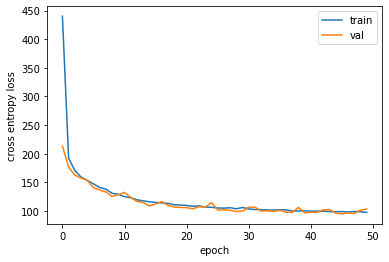

  0%|          | 0/36 [00:00<?, ?it/s]

(2.0498579243818917, 0.5115516401488515)

In [22]:
model = SimpleDenoiserModel([40, 64, 128, 64, 40], [3] * 4).to(DEVICE)
denoiser_train(model, trainnoiseset, valnoiseset, n_epochs=50)
eval_spotter_with_denoiser(model, conv1d_clean_model, valnoiseset)

Как видно качество тут стало лучше, чем после применения на грязных данных модели, которая тренировалась на чистых. Но вот сходу до качества модели, натренированной на грязных данных этот подход не дотягивает.

# Отправка решения

Сгенерим ответы с помощью самой лучшей модели, которая тут получилась

In [23]:
def final_eval(
    spotter, test_data, denoiser=None,
    save_path=os.path.join(START_PATH, 'results.tsv'), batch_size=256
):
    spotter.eval()
    if denoiser:
        denoiser.eval()
    test_loader = DataLoader(
        test_data, batch_size=batch_size, shuffle=True, num_workers=2,
        collate_fn=test_collate_fn
    )
    val_loss, val_acc, val_batches = 0, 0, 0
    results = []
    for X, Y in tqdm.tqdm(test_loader):
        X = X.to(DEVICE)
        if denoiser:
            X = denoiser.forward(X)
        preds = spotter.forward(X)
        classes = torch.argmax(preds, dim=-1).cpu().data.numpy()
        labels = [CLASSES[idx] for idx in classes]
        results.extend([uttid, label] for uttid, label in zip(Y, labels))
    with open(save_path, 'w') as fout:
        for uttid, label in results:
            fout.write(f'{uttid}\t{label}\n')

In [24]:
final_eval(conv1d_noise_model, testset)

  0%|          | 0/367 [00:00<?, ?it/s]